### Submission by Durgesh Vikram Yadav (2011MT10)

# IBM Dataset

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter('ignore')

In [2]:
#Downloading data
ibm = pdr.DataReader('IBM', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30))

In [3]:
#Exporting and saving as csv files
ibm.to_csv('IBM_stock.csv', sep=',')

In [4]:
#Printing the first few lines of data
ibm.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-08-01,191.500000,188.860001,190.500000,189.149994,5181100.0,143.561371
2014-08-04,189.949997,188.600006,189.350006,189.639999,2125900.0,143.933304
2014-08-05,189.199997,186.440002,188.750000,187.100006,3307900.0,142.005493
2014-08-06,186.880005,184.440002,185.360001,185.970001,3847000.0,141.982544
2014-08-07,186.679993,183.580002,186.639999,184.300003,2708600.0,140.707535


Text(0.5, 1.0, 'Close Price history vs Time')

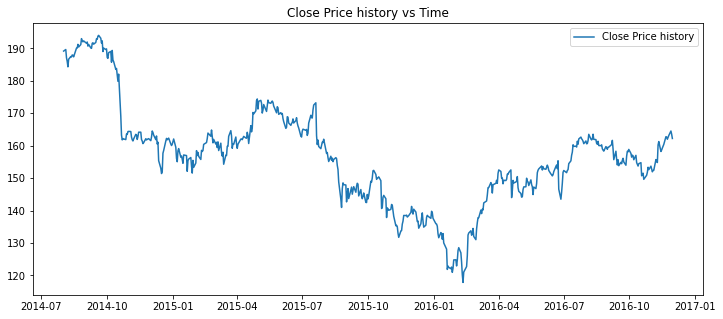

In [5]:
#Visulaizing the data
plt.figure(figsize=(12,5))
plt.plot(ibm['Close'], label='Close Price history')
plt.legend()
plt.title('Close Price history vs Time')

###ADF and KPSS Tests

In [6]:
#Importing libraries
from statsmodels.tsa.stattools import adfuller,kpss

a) ADF Test

In [7]:
def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = ibm[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('Close')

Results of Dickey-Fuller Test for  Close 

Test Statistic                  -2.279273
p-value                          0.178740
#Lags Used                       0.000000
Number of Observations Used    588.000000
Critical Value (1%)             -3.441520
Critical Value (5%)             -2.866468
Critical Value (10%)            -2.569394
dtype: float64


Since p value is greater than 0.05, therefore, we fail to reject the null hypothesis and the data has a unit root and is non-stationary.

b) KPSS Test

In [8]:
def kpss_test(atr):
    timeseries = ibm[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('Close')

Results of KPSS Test for  Close
Test Statistic            1.268862
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


From KPSS Test, the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary).

Both tests conclude that the series is not stationary -> series is not stationary

###ACF and PACF Tests

a) ACF Test

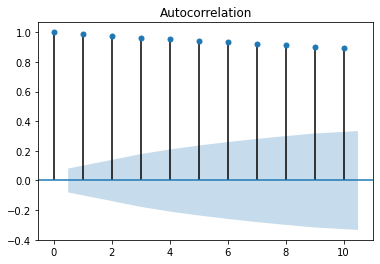

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ibm['Close'].dropna(), lags=10)
plt.show()

b) PACF Test

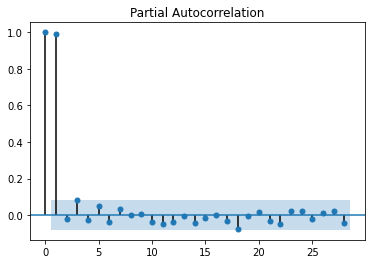

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ibm['Close'])
plt.show()

From ACF and PACF plots, since more than 5% of the plot is outside the shaded region, the data is non stationary.

### Differencing to make data as stationary

In [11]:
#Differencing the data
ibm['diff'] = ibm['Close'].diff(periods=1)

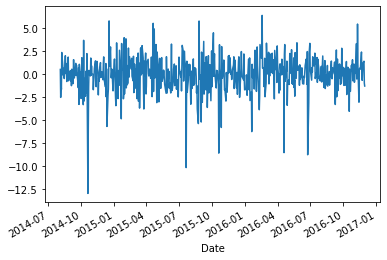

In [12]:
#Visulaizing the differenced data
ibm["diff"].plot()

In [13]:
# ADF Test of differenced data
adf_test('diff')

Results of Dickey-Fuller Test for  diff 

Test Statistic                -1.843371e+01
p-value                        2.166547e-30
#Lags Used                     1.000000e+00
Number of Observations Used    5.860000e+02
Critical Value (1%)           -3.441558e+00
Critical Value (5%)           -2.866485e+00
Critical Value (10%)          -2.569403e+00
dtype: float64


Since p value is less than 0.05, therefore, we reject the null hypothesis and the differenced data is stationary.

In [14]:
# KPSS Test of differenced data
kpss_test('diff')

Results of KPSS Test for  diff
Test Statistic            0.251866
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


From KPSS Test, the test statistic is less than the critical value, we fail to reject the null hypothesis (differenced series is stationary).

Both tests conclude that the differenced series is stationary -> series is stationary.

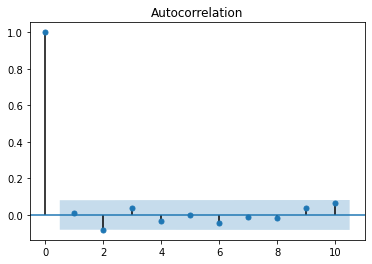

In [15]:
# ACF Test of differenced data
plot_acf(ibm['diff'].dropna(), lags=10)
plt.show()

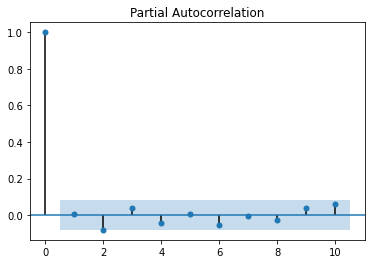

In [16]:
# PACF Test of differenced data
plot_pacf(ibm['diff'].dropna(), lags=10)
plt.show()

From ACF and PACF plots, since less than 5% of the plot is outside the shaded region, the differenced data is stationary.

# ARIMA Model

In [17]:
# Installing pmdarima package
!pip3 install pmdarima

In [18]:
# Importing ARIMA libraries
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [19]:
stepwise_model = auto_arima(ibm["Close"], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2471.231, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2473.595, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2475.556, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2475.548, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2471.911, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2472.974, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2472.874, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2473.290, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2473.745, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2474.239, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2469.536, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2473.858, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2473.866, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2471.303, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [20]:
data = ibm['Close'].dropna().to_numpy()
n = int(len(data)*0.7)
train, test = data[:n], data[n:]

In [21]:
# Fitting Model
model = ARIMA(data, order=(1, 0, 1))
model_fit = model.fit()

In [50]:
# Make Prediction
from sklearn.metrics import mean_squared_error
from math import sqrt

yhat = model_fit.predict(0,len(data)-1)
rmse = sqrt(mean_squared_error(data, yhat))
print('RMSE Value is: ',rmse)

RMSE Value is:  2.2488489672255034


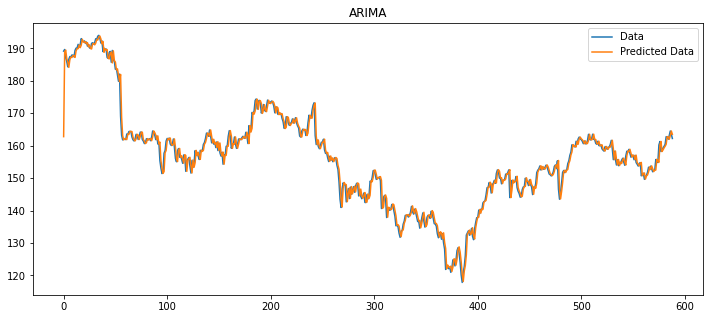

In [54]:
# Visualize Results
plt.figure(figsize=(12,5))
plt.plot(data,label='Data')
plt.plot(yhat,label='Predicted Data')
plt.title('ARIMA')
plt.legend()
plt.show()



---



---



---



# LSTM Model

In [24]:
# Imporint Libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [25]:
df1=ibm['Close']
date = (ibm.index)
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [26]:
# Splitting data
training_size = int(0.8*len(df1))
test_size = len(df1)-training_size
train_data = df1[0:training_size]
test_data = df1[training_size:len(df1)] 

In [27]:
# Converting to dataset matrix
def create_dataset(data, steps=1):
	dataX, dataY = [], []
	for i in range(len(data)-steps-1):
		a = data[i:(i+steps), 0]   
		dataX.append(a)
		dataY.append(data[i + steps, 0]) 
	return np.array(dataX), np.array(dataY) 

In [28]:
# Reshaping
steps = 5
X_train, y_train = create_dataset(train_data, steps)
X_test, ytest = create_dataset(test_data, steps)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
# Fitting Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [31]:
# Inverse Transform
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(ytest.reshape(-1, 1))

In [32]:
# Train data RMSE
rmse1 = np.sqrt(np.mean(np.power((np.array(Y_train)-np.array(train_predict)),2)))
print('RMSE Value of train data with LSTM model',rmse1)

RMSE Value of train data with LSTM model 3.459834091805127


In [33]:
# Test Data RMSE
rmse2 = np.sqrt(np.mean(np.power((np.array(Y_test)-np.array(test_predict)),2)))
print('RMSE Value of test data with LSTM model',rmse2)

RMSE Value of test data with LSTM model 2.8068576537297374


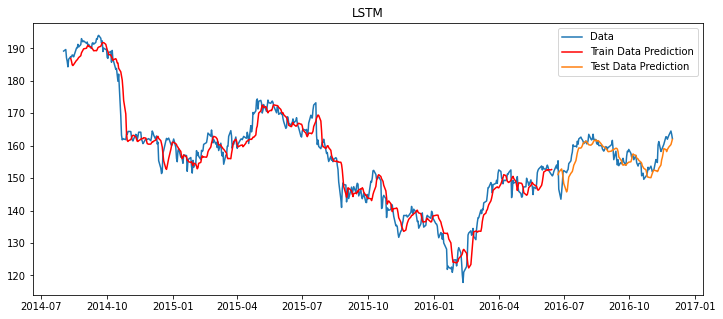

In [34]:
# Visulaize Predictions
pre=5
plt.figure(figsize=(12,5))
plt.plot(date,scaler.inverse_transform(df1), label='Data')
plt.plot(date[pre+1:training_size],train_predict, label='Train Data Prediction', color='red')
plt.plot(date[training_size+pre+1:],test_predict, label='Test Data Prediction')
plt.legend()
plt.title('LSTM')
plt.show()



---



---



---



# Exponential Smoothing

In [35]:
# Importing Libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [36]:
data = ibm['Close'].to_numpy()
date = (ibm.index)

In [37]:
#Exponentital Smoothening
Exp_model = ExponentialSmoothing(ibm.Close,trend='mul',seasonal='mul',seasonal_periods=4)
ibm['Exp_Smoothening'] = Exp_model.fit(smoothing_level = 0.9,smoothing_slope= 0.1,smoothing_seasonal = 0.2).fittedvalues.shift(0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [38]:
#RMSE Value
rmse3 = np.sqrt(np.mean(np.power((np.array(data)-np.array(ibm.Exp_Smoothening)),2)))
print('RMSE value with Exponential Smoothing: ',rmse3)

RMSE value with Exponential Smoothing:  2.2503866549923073


Text(0.5, 1.0, 'Exponential Smoothing')

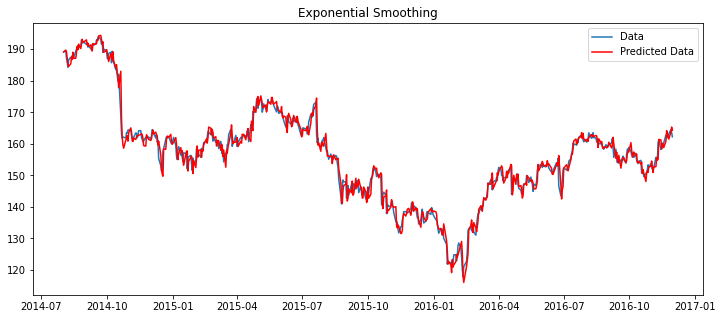

In [39]:
#Visulaize Data and Prediction
plt.figure(figsize=(12,5))
plt.plot(date,data, label='Data')
plt.plot(date,ibm.Exp_Smoothening, label='Predicted Data',color = 'red')
plt.legend()
plt.title('Exponential Smoothing')



---



---



---



#Prohet Model

In [40]:
#Importing Library
from fbprophet import Prophet

In [41]:
#Adding Date Column to DataFrame
ibm['Date'] = pd.date_range(start='8/1/2014', periods=len(ibm.Close), freq='D')
ibm_features = ibm[['Date','Close']]
ibm_features = ibm_features.rename(columns = {"Date":"ds","Close":"y"})

In [42]:
#Applying Prophet model
ibm_model = Prophet(daily_seasonality = True) # stock prices have daily seasonality
ibm_model.fit(ibm_features)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [43]:
#Predicting for future 30 days
future = ibm_model.make_future_dataframe(periods = 30)
prediction = ibm_model.predict(future)

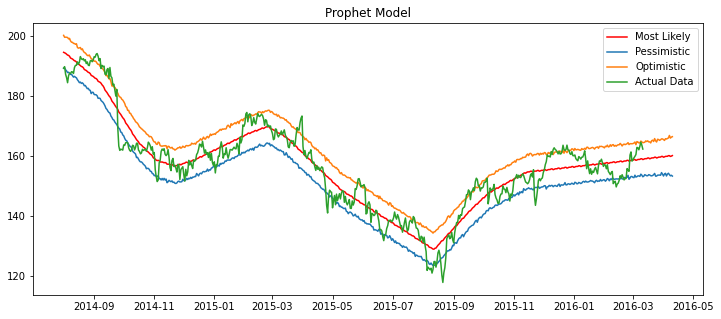

In [44]:
#Visualizing the results
plt.figure(figsize=(12,5))
plt.plot(prediction['ds'],prediction['yhat'],color='red',label='Most Likely')
plt.plot(prediction['ds'],prediction['yhat_lower'],label='Pessimistic')
plt.plot(prediction['ds'],prediction['yhat_upper'],label='Optimistic')
plt.plot(ibm_features['ds'],ibm_features['y'],label='Actual Data')
plt.legend()
plt.title('Prophet Model')
plt.show()